# CNN in MNIST and Fashion-MNIST

In this notebook, we implement and train a **two-layer Convolutional Neural Network (CNN)** inspired by the **TinyVGG architecture**, a simplified version of the VGG family of models that is often used for teaching and experimentation. This CNN is designed to build a classification model for two of the most classic benchmark datasets in computer vision: **MNIST** and **Fashion-MNIST**. Both datasets are widely used in machine learning research and education because they provide a simple yet effective way to test image recognition algorithms.

- **MNIST** consists of 70,000 grayscale images of handwritten digits (0–9), each with a resolution of 28x28 pixels. The task is to correctly classify each image into the corresponding digit class.  
- **Fashion-MNIST** is a more challenging replacement for MNIST. It also contains 70,000 grayscale images of size 28x28, but instead of digits, the classes represent different fashion items such as shoes, shirts, and bags.

By using a **CNN architecture inspired by TinyVGG**, we leverage the advantages of convolutional layers for feature extraction, while keeping the model compact and computationally efficient. CNNs are particularly effective for image classification tasks because they can capture spatial relationships in the data, learning local patterns like edges, textures, and shapes that are crucial for recognition.

We also use **Weights & Biases (wandb)** to **track training and test metrics, log hyperparameters, and visualize the experiment progress** in real time. This allows us to compare different runs, monitor model performance, and maintain an organized record of experiments.

In this notebook, we will:  
1. Load and preprocess the MNIST and Fashion-MNIST datasets using **PyTorch** and **torchvision**.  
2. Define and implement a **TinyVGG-style two-layer CNN architecture**.  
3. Train the model on the training set and evaluate its performance on the test set.  
4. Log all metrics to **wandb** for tracking and visualization.  
5. Compare the results between MNIST and Fashion-MNIST, highlighting the differences in model accuracy and generalization.  

This exercise not only demonstrates how to build CNNs in PyTorch but also serves as a practical introduction to deep learning for computer vision tasks.  



In [134]:
#!pip install tqdm


In [37]:
# import libraries
import wandb
wandb.login()
#Import Pytorch
import torch
from torch import nn

#Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#Import matplotlib
import matplotlib.pyplot as pl

#helpers
import helper as h
import models

from torch.utils.data import DataLoader
from tqdm import tqdm


# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## 1. Getting and exploring the datasets  

In this section we load the **MNIST** and **Fashion-MNIST** datasets using `torchvision`.  

- **MNIST** is a dataset of handwritten digits (0–9), consisting of **60,000 training images** and **10,000 test images**, all in grayscale with a resolution of **28 × 28 pixels**.  
- **Fashion-MNIST** has the same format and size but contains **clothing items** (such as t-shirts, shoes, and coats) instead of digits.  

We explore both datasets by:  
- Checking their structure (number of samples, image shape, number of classes).  
- Visualizing some random examples to understand what the model will learn to recognize.  


In [6]:
# Loading the datasets

torch.manual_seed(42)

#MNIST
MNIST_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
MNIST_test_data=datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

#Fashion-MNIST
fashionMNIST_train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
fashionMNIST_test_data=datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

We have loaded the **MNIST** and **Fashion-MNIST** datasets, with separate training and test sets, and converted all images to tensors. Let's visualize some examples and exlore the lengths of the sets.

In [7]:
print(f"MNIST:           Training samples: {len(MNIST_train_data )}   |   Test samples: {len(MNIST_test_data )}")
print(f"Fashion-MNIST:   Training samples: {len(fashionMNIST_train_data )}   |   Test samples: {len(fashionMNIST_test_data )}")

MNIST:           Training samples: 60000   |   Test samples: 10000
Fashion-MNIST:   Training samples: 60000   |   Test samples: 10000


In [8]:
# Get the classes names into a list
MNIST_classes = MNIST_train_data.classes
fashionMNIST_classes = fashionMNIST_train_data.classes

print(MNIST_classes)
print(fashionMNIST_classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [9]:
#### Explore the firs image in each dataset ####

# Get the firs training example
MNIST_image, MNIST_label= MNIST_train_data[0]
fashionMNIST_image, fashionMNIST_label= fashionMNIST_train_data[0]

print(f"MNIST:           Image shape: {MNIST_image.shape}   |   First label: {MNIST_label}")
print(f"Fashion-MNIST:   Image shape: {fashionMNIST_image.shape}   |   First label: {fashionMNIST_label}")

MNIST:           Image shape: torch.Size([1, 28, 28])   |   First label: 5
Fashion-MNIST:   Image shape: torch.Size([1, 28, 28])   |   First label: 9


We see that both datasets consist of images of size (1, 28, 28) and belong to 10 different categories. We conclude the exploration by displaying some examples from each dataset. We use the helper function `plot_image_grid` from `helper.py`

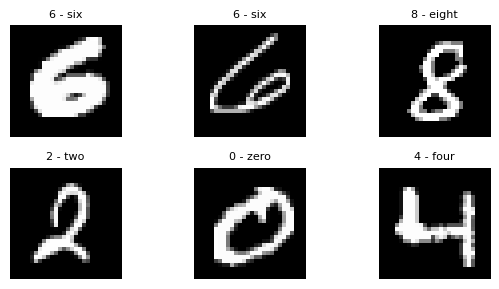

In [10]:
torch.manual_seed(42)
h.plot_images_grid(data=MNIST_train_data, class_names=MNIST_classes, rows=2, cols=3, predictions=None, figsize=(6, 3))

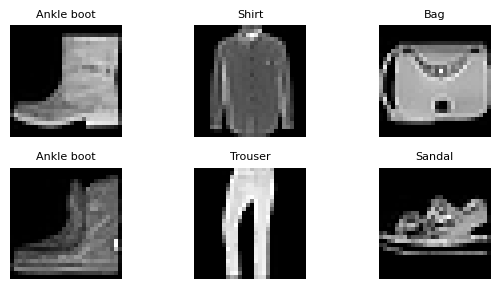

In [11]:
torch.manual_seed(42)
h.plot_images_grid(data=fashionMNIST_train_data, class_names=fashionMNIST_classes, rows=2, cols=3, predictions=None, figsize=(6, 3))

# Loss Function

For all the models, we use the **CrossEntropyLoss** function from `torch.nn`. Recall that `CrossEntropyLoss` **combines `LogSoftmax` and `NLLLoss` internally**, so our network can simply output **raw logits** without applying a softmax at the end. This makes the implementation simpler and numerically more stable.

For evaluation, we use **accuracy** as our metric implemented in `helper.py`.


In [12]:
loss_fn = nn.CrossEntropyLoss()
h.acc_fn = h.accuracy_fn

## Baseline

The baseline TinyVGG model consists of **two convolutional blocks**:

1. **Convolutional Block 1**
   - Conv2d (3x3, 16 filters, stride=1, padding=1).
   - Conv2d (3x3, 16 filters, stride=1, padding=1) .
   - ReLU activations: Introduce non-linearity.
   - MaxPool2d (2x2): Reduces spatial dimensions by half (28x28 → 14x14), summarizing local features.

2. **Convolutional Block 2**
   - Conv2d (3x3, 16 filters, stride=1, padding=1).
   - Conv2d (3x3, 16 filters, stride=1, padding=1).
   - ReLU activations.
   - MaxPool2d (2x2) Reduces dimensions further (14x14 → 7x7).

3. **Classifier**
   - Flatten: Converts the 3D feature maps into a 1D vector (16×7×7 = 784 features per sample).
   - Linear layer: Maps the flattened features to 10 output classes (for FashionMNIST/MNIST).

This simple architecture allows the model to learn hierarchical representations of the images while keeping the number of parameters low. For our baseline, we use the `TinyVGG` class defined in `models.py`.




In [13]:
MNIST_baseline_model=models.TinyVGG(in_channels=1,
                       hidden_units=[16,16],
                       out_features=10,
                       dropout=0).to(device)
fashionMNIST_baseline_model=models.TinyVGG(in_channels=1,
                       hidden_units=[16,16],
                       out_features=10,
                       dropout=0).to(device)

During training, the data is divided into mini-batches of 32 images each and we use the `SGD` optimizer with a learning rate of `0.1`. For this propuse lets beging by crating our dataloaders and defining our optimizer

In [14]:
BATCH_SIZE= 32

# Create DataLoaders
MNIST_train_loader = h.create_loader(MNIST_train_data, batch_size=BATCH_SIZE, shuffle=True, name="MNIST Train")
MNIST_test_loader  = h.create_loader(MNIST_test_data, batch_size=BATCH_SIZE, shuffle=False, name="MNIST Test")

fashionMNIST_train_loader = h.create_loader(fashionMNIST_train_data, batch_size=BATCH_SIZE, shuffle=True, name="FashionMNIST Train")
fashionMNIST_test_loader  = h.create_loader(fashionMNIST_test_data, batch_size=BATCH_SIZE, shuffle=False, name="FashionMNIST Test")

print("--------------------- Dataloaders created -------------------")

MNIST Train: 1875 batches of 32 images
First batch shape - images: torch.Size([32, 1, 28, 28]), labels: torch.Size([32])

MNIST Test: 313 batches of 32 images
First batch shape - images: torch.Size([32, 1, 28, 28]), labels: torch.Size([32])

FashionMNIST Train: 1875 batches of 32 images
First batch shape - images: torch.Size([32, 1, 28, 28]), labels: torch.Size([32])

FashionMNIST Test: 313 batches of 32 images
First batch shape - images: torch.Size([32, 1, 28, 28]), labels: torch.Size([32])

--------------------- Dataloaders created -------------------


In [15]:
# Set optimizers
MNIST_optimizer = torch.optim.SGD(params=MNIST_baseline_model.parameters(), lr=0.1)
fashionMNIST_optimizer = torch.optim.SGD(params=fashionMNIST_baseline_model.parameters(), lr=0.1)


### Baseline training

In [146]:
torch.manual_seed(42)
h.train_with_wandb(model=MNIST_baseline_model,
                 train_loader=MNIST_train_loader,
                 test_loader=MNIST_test_loader,
                 loss_fn=loss_fn,
                 optimizer=MNIST_optimizer,
                 accuracy_fn=h.accuracy_fn,
                 device=device,
                 epochs=5,
                 project_name="mnist",
                 hidden_units=[16,16],
                 dropout=0.0)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
---------
Train loss: 0.26446 | Train acc: 91.07%


 20%|██        | 1/5 [00:12<00:48, 12.11s/it]

Test loss: 0.06334 | Test acc: 98.21%

Epoch: 1 
---------
Train loss: 0.06485 | Train acc: 97.96%


 40%|████      | 2/5 [00:24<00:36, 12.17s/it]

Test loss: 0.05468 | Test acc: 98.26%

Epoch: 2 
---------
Train loss: 0.04894 | Train acc: 98.47%


 60%|██████    | 3/5 [00:37<00:25, 12.68s/it]

Test loss: 0.05702 | Test acc: 98.15%

Epoch: 3 
---------
Train loss: 0.04166 | Train acc: 98.69%


 80%|████████  | 4/5 [00:50<00:12, 12.66s/it]

Test loss: 0.04075 | Test acc: 98.79%

Epoch: 4 
---------
Train loss: 0.03514 | Train acc: 98.92%


100%|██████████| 5/5 [01:02<00:00, 12.44s/it]

Test loss: 0.03604 | Test acc: 98.75%



epoch,▁▃▅▆█
test_acc,▂▂▁██
test_loss,█▆▆▂▁
train_acc,▁▇███
train_loss,█▂▁▁▁
epoch,4
test_acc,0.98752
test_loss,0.03604
train_acc,0.98918
train_loss,0.03514


In [147]:
torch.manual_seed(42)
h.train_with_wandb(model=fashionMNIST_baseline_model,
                 train_loader=fashionMNIST_train_loader,
                 test_loader=fashionMNIST_test_loader,
                 loss_fn=loss_fn,
                 optimizer=fashionMNIST_optimizer,
                 accuracy_fn=h.accuracy_fn,
                 device=device,
                 epochs=5,
                 project_name="fashion mnist",
                 hidden_units=[16,16],
                 dropout=0.0)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
---------
Train loss: 0.55303 | Train acc: 80.30%


 20%|██        | 1/5 [00:11<00:47, 11.93s/it]

Test loss: 0.36890 | Test acc: 86.69%

Epoch: 1 
---------
Train loss: 0.32652 | Train acc: 88.31%


 40%|████      | 2/5 [00:24<00:36, 12.01s/it]

Test loss: 0.31692 | Test acc: 88.51%

Epoch: 2 
---------
Train loss: 0.28740 | Train acc: 89.71%


 60%|██████    | 3/5 [00:35<00:23, 11.90s/it]

Test loss: 0.29721 | Test acc: 89.63%

Epoch: 3 
---------
Train loss: 0.26422 | Train acc: 90.48%


 80%|████████  | 4/5 [00:47<00:11, 11.85s/it]

Test loss: 0.28969 | Test acc: 89.34%

Epoch: 4 
---------
Train loss: 0.24958 | Train acc: 90.96%


100%|██████████| 5/5 [00:59<00:00, 11.86s/it]

Test loss: 0.27416 | Test acc: 90.14%



epoch,▁▃▅▆█
test_acc,▁▅▇▆█
test_loss,█▄▃▂▁
train_acc,▁▆▇██
train_loss,█▃▂▁▁
epoch,4
test_acc,0.90136
test_loss,0.27416
train_acc,0.90963
train_loss,0.24958


# Experimentation


### Training for more epochs
We can train our model for more epochs. Let's try to train MNIST for 15 epochs and fashion-Mnist for 20.

In [16]:
# Define models
MNIST_model_1=models.TinyVGG(in_channels=1,
                       hidden_units=[16,16],
                       out_features=10,
                       dropout=0).to(device)
fashionMNIST_model_1=models.TinyVGG(in_channels=1,
                       hidden_units=[16,16],
                       out_features=10,
                       dropout=0).to(device)

# Set optimizers
MNIST_optimizer = torch.optim.SGD(params=MNIST_model_1.parameters(), lr=0.1)
fashionMNIST_optimizer = torch.optim.SGD(params=fashionMNIST_model_1.parameters(), lr=0.1)

In [17]:
torch.manual_seed(42)
h.train_with_wandb(model=MNIST_model_1,
                 train_loader=MNIST_train_loader,
                 test_loader=MNIST_test_loader,
                 loss_fn=loss_fn,
                 optimizer=MNIST_optimizer,
                 accuracy_fn=h.accuracy_fn,
                 device=device,
                 epochs=15,
                 project_name="mnist",
                 hidden_units=[16,16],
                 dropout=0.0)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 
---------
Train loss: 0.28460 | Train acc: 90.38%


  7%|▋         | 1/15 [00:12<02:52, 12.33s/it]

Test loss: 0.06501 | Test acc: 97.99%

Epoch: 1 
---------
Train loss: 0.06224 | Train acc: 98.13%


 13%|█▎        | 2/15 [00:24<02:38, 12.22s/it]

Test loss: 0.04822 | Test acc: 98.50%

Epoch: 2 
---------
Train loss: 0.04604 | Train acc: 98.58%


 20%|██        | 3/15 [00:37<02:31, 12.62s/it]

Test loss: 0.04305 | Test acc: 98.57%

Epoch: 3 
---------
Train loss: 0.03809 | Train acc: 98.81%


 27%|██▋       | 4/15 [00:52<02:27, 13.36s/it]

Test loss: 0.04200 | Test acc: 98.69%

Epoch: 4 
---------
Train loss: 0.03346 | Train acc: 99.01%


 33%|███▎      | 5/15 [01:04<02:10, 13.08s/it]

Test loss: 0.03890 | Test acc: 98.68%

Epoch: 5 
---------
Train loss: 0.02907 | Train acc: 99.08%


 40%|████      | 6/15 [01:17<01:56, 12.93s/it]

Test loss: 0.03286 | Test acc: 98.90%

Epoch: 6 
---------
Train loss: 0.02545 | Train acc: 99.17%


 47%|████▋     | 7/15 [01:29<01:41, 12.64s/it]

Test loss: 0.03697 | Test acc: 98.64%

Epoch: 7 
---------
Train loss: 0.02370 | Train acc: 99.27%


 53%|█████▎    | 8/15 [01:41<01:26, 12.42s/it]

Test loss: 0.02997 | Test acc: 99.05%

Epoch: 8 
---------
Train loss: 0.02172 | Train acc: 99.33%


 60%|██████    | 9/15 [01:53<01:13, 12.28s/it]

Test loss: 0.03345 | Test acc: 98.97%

Epoch: 9 
---------
Train loss: 0.01940 | Train acc: 99.37%


 67%|██████▋   | 10/15 [02:05<01:01, 12.22s/it]

Test loss: 0.02742 | Test acc: 99.09%

Epoch: 10 
---------
Train loss: 0.01888 | Train acc: 99.39%


 73%|███████▎  | 11/15 [02:17<00:48, 12.14s/it]

Test loss: 0.02746 | Test acc: 99.10%

Epoch: 11 
---------
Train loss: 0.01694 | Train acc: 99.45%


 80%|████████  | 12/15 [02:29<00:36, 12.10s/it]

Test loss: 0.04600 | Test acc: 98.62%

Epoch: 12 
---------
Train loss: 0.01567 | Train acc: 99.49%


 87%|████████▋ | 13/15 [02:41<00:24, 12.01s/it]

Test loss: 0.03696 | Test acc: 98.92%

Epoch: 13 
---------
Train loss: 0.01544 | Train acc: 99.50%


 93%|█████████▎| 14/15 [02:53<00:11, 11.99s/it]

Test loss: 0.02896 | Test acc: 99.16%

Epoch: 14 
---------
Train loss: 0.01266 | Train acc: 99.60%


100%|██████████| 15/15 [03:05<00:00, 12.34s/it]

Test loss: 0.03320 | Test acc: 99.01%



epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁▄▄▅▅▆▅▇▇██▅▇█▇
test_loss,█▅▄▄▃▂▃▁▂▁▁▄▃▁▂
train_acc,▁▇▇▇███████████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,14
test_acc,0.99012
test_loss,0.0332
train_acc,0.996
train_loss,0.01266


In [18]:
torch.manual_seed(42)
h.train_with_wandb(model=fashionMNIST_model_1,
                 train_loader=fashionMNIST_train_loader,
                 test_loader=fashionMNIST_test_loader,
                 loss_fn=loss_fn,
                 optimizer=fashionMNIST_optimizer,
                 accuracy_fn=h.accuracy_fn,
                 device=device,
                 epochs=20,
                 project_name="fashion mnist",
                 hidden_units=[16,16],
                 dropout=0.0)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 
---------
Train loss: 0.51904 | Train acc: 81.45%


  5%|▌         | 1/20 [00:11<03:47, 11.96s/it]

Test loss: 0.36282 | Test acc: 86.85%

Epoch: 1 
---------
Train loss: 0.33214 | Train acc: 88.09%


 10%|█         | 2/20 [00:23<03:34, 11.93s/it]

Test loss: 0.33120 | Test acc: 88.02%

Epoch: 2 
---------
Train loss: 0.29121 | Train acc: 89.55%


 15%|█▌        | 3/20 [00:35<03:23, 11.96s/it]

Test loss: 0.29642 | Test acc: 89.34%

Epoch: 3 
---------
Train loss: 0.26581 | Train acc: 90.53%


 20%|██        | 4/20 [00:47<03:11, 11.97s/it]

Test loss: 0.28197 | Test acc: 89.77%

Epoch: 4 
---------
Train loss: 0.25079 | Train acc: 90.99%


 25%|██▌       | 5/20 [00:59<03:00, 12.02s/it]

Test loss: 0.27781 | Test acc: 89.77%

Epoch: 5 
---------
Train loss: 0.24080 | Train acc: 91.38%


 30%|███       | 6/20 [01:12<02:48, 12.03s/it]

Test loss: 0.27455 | Test acc: 90.11%

Epoch: 6 
---------
Train loss: 0.23205 | Train acc: 91.76%


 35%|███▌      | 7/20 [01:24<02:36, 12.06s/it]

Test loss: 0.27314 | Test acc: 90.27%

Epoch: 7 
---------
Train loss: 0.22425 | Train acc: 91.92%


 40%|████      | 8/20 [01:36<02:24, 12.06s/it]

Test loss: 0.26705 | Test acc: 90.28%

Epoch: 8 
---------
Train loss: 0.21742 | Train acc: 92.11%


 45%|████▌     | 9/20 [01:48<02:12, 12.06s/it]

Test loss: 0.26340 | Test acc: 90.59%

Epoch: 9 
---------
Train loss: 0.21129 | Train acc: 92.47%


 50%|█████     | 10/20 [02:00<02:01, 12.12s/it]

Test loss: 0.26804 | Test acc: 90.75%

Epoch: 10 
---------
Train loss: 0.20852 | Train acc: 92.49%


 55%|█████▌    | 11/20 [02:12<01:48, 12.09s/it]

Test loss: 0.26740 | Test acc: 90.69%

Epoch: 11 
---------
Train loss: 0.20225 | Train acc: 92.68%


 60%|██████    | 12/20 [02:24<01:36, 12.08s/it]

Test loss: 0.26524 | Test acc: 90.84%

Epoch: 12 
---------
Train loss: 0.19779 | Train acc: 92.78%


 65%|██████▌   | 13/20 [02:36<01:24, 12.07s/it]

Test loss: 0.26114 | Test acc: 91.34%

Epoch: 13 
---------
Train loss: 0.19545 | Train acc: 92.92%


 70%|███████   | 14/20 [02:48<01:12, 12.06s/it]

Test loss: 0.26193 | Test acc: 90.86%

Epoch: 14 
---------
Train loss: 0.19168 | Train acc: 92.97%


 75%|███████▌  | 15/20 [03:00<01:00, 12.08s/it]

Test loss: 0.28905 | Test acc: 90.19%

Epoch: 15 
---------
Train loss: 0.19028 | Train acc: 93.12%


 80%|████████  | 16/20 [03:12<00:48, 12.09s/it]

Test loss: 0.27652 | Test acc: 90.35%

Epoch: 16 
---------
Train loss: 0.18975 | Train acc: 93.19%


 85%|████████▌ | 17/20 [03:25<00:36, 12.11s/it]

Test loss: 0.28389 | Test acc: 90.53%

Epoch: 17 
---------
Train loss: 0.18462 | Train acc: 93.31%


 90%|█████████ | 18/20 [03:37<00:24, 12.09s/it]

Test loss: 0.26841 | Test acc: 90.69%

Epoch: 18 
---------
Train loss: 0.18507 | Train acc: 93.27%


 95%|█████████▌| 19/20 [03:49<00:12, 12.07s/it]

Test loss: 0.26800 | Test acc: 91.24%

Epoch: 19 
---------
Train loss: 0.18355 | Train acc: 93.35%


100%|██████████| 20/20 [04:01<00:00, 12.05s/it]

Test loss: 0.29510 | Test acc: 89.62%



epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁▃▅▆▆▆▆▆▇▇▇▇█▇▆▆▇▇█▅
test_loss,█▆▃▂▂▂▂▁▁▁▁▁▁▁▃▂▃▂▁▃
train_acc,▁▅▆▆▇▇▇▇▇▇▇█████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,19
test_acc,0.89617
test_loss,0.2951
train_acc,0.93347
train_loss,0.18355


We see that the MNIST model got an accuracy of `99.01` when the baseline_model is trained for `15` epochs.

### Changing the optimizer for the Fashion MNIST Model
We will use the Adam optimizer with a learning rate of `0.001` and train for `20` epochs.

In [19]:
# Define models
fashionMNIST_model_1=models.TinyVGG(in_channels=1,
                       hidden_units=[16,16],
                       out_features=10,
                       dropout=0).to(device)

# Set optimizers
fashionMNIST_optimizer = torch.optim.Adam(params=fashionMNIST_model_1.parameters(), lr=0.001)

torch.manual_seed(42)
h.train_with_wandb(model=fashionMNIST_model_1,
                 train_loader=fashionMNIST_train_loader,
                 test_loader=fashionMNIST_test_loader,
                 loss_fn=loss_fn,
                 optimizer=fashionMNIST_optimizer,
                 accuracy_fn=h.accuracy_fn,
                 device=device,
                 epochs=10,
                 project_name="fashion mnist",
                 hidden_units=[16,16],
                 dropout=0.0)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
---------
Train loss: 0.48801 | Train acc: 82.18%


 10%|█         | 1/10 [00:12<01:53, 12.60s/it]

Test loss: 0.37784 | Test acc: 86.55%

Epoch: 1 
---------
Train loss: 0.32509 | Train acc: 88.33%


 20%|██        | 2/10 [00:25<01:41, 12.63s/it]

Test loss: 0.32631 | Test acc: 87.88%

Epoch: 2 
---------
Train loss: 0.28055 | Train acc: 89.90%


 30%|███       | 3/10 [00:37<01:28, 12.60s/it]

Test loss: 0.29558 | Test acc: 89.02%

Epoch: 3 
---------
Train loss: 0.25249 | Train acc: 90.90%


 40%|████      | 4/10 [00:50<01:15, 12.64s/it]

Test loss: 0.27945 | Test acc: 90.08%

Epoch: 4 
---------
Train loss: 0.23265 | Train acc: 91.53%


 50%|█████     | 5/10 [01:03<01:02, 12.60s/it]

Test loss: 0.25598 | Test acc: 90.90%

Epoch: 5 
---------
Train loss: 0.21846 | Train acc: 92.01%


 60%|██████    | 6/10 [01:15<00:50, 12.59s/it]

Test loss: 0.25012 | Test acc: 90.84%

Epoch: 6 
---------
Train loss: 0.20737 | Train acc: 92.61%


 70%|███████   | 7/10 [01:28<00:37, 12.58s/it]

Test loss: 0.24975 | Test acc: 90.76%

Epoch: 7 
---------
Train loss: 0.19763 | Train acc: 92.86%


 80%|████████  | 8/10 [01:40<00:25, 12.58s/it]

Test loss: 0.24083 | Test acc: 91.42%

Epoch: 8 
---------
Train loss: 0.19099 | Train acc: 93.01%


 90%|█████████ | 9/10 [01:53<00:12, 12.58s/it]

Test loss: 0.24929 | Test acc: 91.09%

Epoch: 9 
---------
Train loss: 0.18122 | Train acc: 93.34%


100%|██████████| 10/10 [02:05<00:00, 12.59s/it]

Test loss: 0.26018 | Test acc: 91.10%



epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁▃▅▆▇▇▇███
test_loss,█▅▄▃▂▁▁▁▁▂
train_acc,▁▅▆▆▇▇████
train_loss,█▄▃▃▂▂▂▁▁▁
epoch,9
test_acc,0.91104
test_loss,0.26018
train_acc,0.93338
train_loss,0.18122


We note that the Adam optimizer performs better than SGD, and training for 10 epochs is sufficient to achieve a stable convergence.

### Adding dropout and increasing hidden units
Now we are going to experiment by adding dropout and increasing the number of hidden units in our TinyVGG model to see how these changes affect its performance on the MNIST and Fashion-MNIST datasets.

In [20]:
MNIST_model_1=models.TinyVGG(in_channels=1,
                       hidden_units=[32,32],
                       out_features=10,
                       dropout=0.2).to(device)
MNIST_optimizer = torch.optim.Adam(params=MNIST_model_1.parameters(), lr=0.001)

In [21]:
torch.manual_seed(42)
h.train_with_wandb(model=MNIST_model_1,
                 train_loader=MNIST_train_loader,
                 test_loader=MNIST_test_loader,
                 loss_fn=loss_fn,
                 optimizer=MNIST_optimizer,
                 accuracy_fn=h.accuracy_fn,
                 device=device,
                 epochs=25,
                 project_name="mnist",
                 hidden_units=[32,32],
                 dropout=0.2)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 
---------
Train loss: 0.40386 | Train acc: 83.22%


  4%|▍         | 1/25 [00:13<05:14, 13.10s/it]

Test loss: 0.05325 | Test acc: 98.43%

Epoch: 1 
---------
Train loss: 0.26741 | Train acc: 87.36%


  8%|▊         | 2/25 [00:26<05:00, 13.06s/it]

Test loss: 0.03516 | Test acc: 98.78%

Epoch: 2 
---------
Train loss: 0.25429 | Train acc: 87.43%


 12%|█▏        | 3/25 [00:39<04:47, 13.06s/it]

Test loss: 0.03027 | Test acc: 99.04%

Epoch: 3 
---------
Train loss: 0.24067 | Train acc: 87.64%


 16%|█▌        | 4/25 [00:52<04:34, 13.06s/it]

Test loss: 0.02489 | Test acc: 99.13%

Epoch: 4 
---------
Train loss: 0.23402 | Train acc: 88.03%


 20%|██        | 5/25 [01:05<04:21, 13.06s/it]

Test loss: 0.02200 | Test acc: 99.26%

Epoch: 5 
---------
Train loss: 0.23360 | Train acc: 87.68%


 24%|██▍       | 6/25 [01:18<04:07, 13.04s/it]

Test loss: 0.02214 | Test acc: 99.31%

Epoch: 6 
---------
Train loss: 0.22586 | Train acc: 88.02%


 28%|██▊       | 7/25 [01:31<03:54, 13.03s/it]

Test loss: 0.02149 | Test acc: 99.34%

Epoch: 7 
---------
Train loss: 0.22420 | Train acc: 88.08%


 32%|███▏      | 8/25 [01:44<03:41, 13.04s/it]

Test loss: 0.02559 | Test acc: 99.20%

Epoch: 8 
---------
Train loss: 0.22162 | Train acc: 88.09%


 36%|███▌      | 9/25 [01:57<03:28, 13.03s/it]

Test loss: 0.02470 | Test acc: 99.17%

Epoch: 9 
---------
Train loss: 0.21846 | Train acc: 88.22%


 40%|████      | 10/25 [02:10<03:15, 13.04s/it]

Test loss: 0.02067 | Test acc: 99.32%

Epoch: 10 
---------
Train loss: 0.21872 | Train acc: 88.23%


 44%|████▍     | 11/25 [02:23<03:02, 13.05s/it]

Test loss: 0.02267 | Test acc: 99.36%

Epoch: 11 
---------
Train loss: 0.21717 | Train acc: 88.25%


 48%|████▊     | 12/25 [02:36<02:49, 13.02s/it]

Test loss: 0.02544 | Test acc: 99.22%

Epoch: 12 
---------
Train loss: 0.21445 | Train acc: 88.21%


 52%|█████▏    | 13/25 [02:49<02:36, 13.01s/it]

Test loss: 0.02278 | Test acc: 99.41%

Epoch: 13 
---------
Train loss: 0.21116 | Train acc: 88.37%


 56%|█████▌    | 14/25 [03:02<02:23, 13.01s/it]

Test loss: 0.01951 | Test acc: 99.39%

Epoch: 14 
---------
Train loss: 0.20639 | Train acc: 88.64%


 60%|██████    | 15/25 [03:15<02:10, 13.04s/it]

Test loss: 0.02273 | Test acc: 99.40%

Epoch: 15 
---------
Train loss: 0.21022 | Train acc: 88.40%


 64%|██████▍   | 16/25 [03:28<01:57, 13.05s/it]

Test loss: 0.02633 | Test acc: 99.33%

Epoch: 16 
---------
Train loss: 0.21180 | Train acc: 88.44%


 68%|██████▊   | 17/25 [03:41<01:44, 13.08s/it]

Test loss: 0.01968 | Test acc: 99.40%

Epoch: 17 
---------
Train loss: 0.20534 | Train acc: 88.56%


 72%|███████▏  | 18/25 [03:54<01:31, 13.10s/it]

Test loss: 0.02351 | Test acc: 99.32%

Epoch: 18 
---------
Train loss: 0.20811 | Train acc: 88.35%


 76%|███████▌  | 19/25 [04:07<01:18, 13.07s/it]

Test loss: 0.02216 | Test acc: 99.36%

Epoch: 19 
---------
Train loss: 0.20888 | Train acc: 88.32%


 80%|████████  | 20/25 [04:20<01:05, 13.05s/it]

Test loss: 0.02388 | Test acc: 99.37%

Epoch: 20 
---------
Train loss: 0.20709 | Train acc: 88.51%


 84%|████████▍ | 21/25 [04:34<00:52, 13.06s/it]

Test loss: 0.02375 | Test acc: 99.35%

Epoch: 21 
---------
Train loss: 0.20650 | Train acc: 88.54%


 88%|████████▊ | 22/25 [04:47<00:39, 13.05s/it]

Test loss: 0.01892 | Test acc: 99.44%

Epoch: 22 
---------
Train loss: 0.20831 | Train acc: 88.32%


 92%|█████████▏| 23/25 [05:00<00:26, 13.04s/it]

Test loss: 0.02517 | Test acc: 99.34%

Epoch: 23 
---------
Train loss: 0.20388 | Train acc: 88.59%


 96%|█████████▌| 24/25 [05:13<00:13, 13.05s/it]

Test loss: 0.01928 | Test acc: 99.43%

Epoch: 24 
---------
Train loss: 0.20379 | Train acc: 88.65%


100%|██████████| 25/25 [05:26<00:00, 13.05s/it]

Test loss: 0.02124 | Test acc: 99.46%



epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_acc,▁▃▅▆▇▇▇▆▆▇▇▆███▇█▇▇▇▇█▇██
test_loss,█▄▃▂▂▂▂▂▂▁▂▂▂▁▂▃▁▂▂▂▂▁▂▁▁
train_acc,▁▆▆▇▇▇▇▇▇▇▇▇▇████████████
train_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
test_acc,0.99461
test_loss,0.02124
train_acc,0.88648
train_loss,0.20379


We can plot the progress. We include a plot from mathplotlib and an interactive plot per epoch.

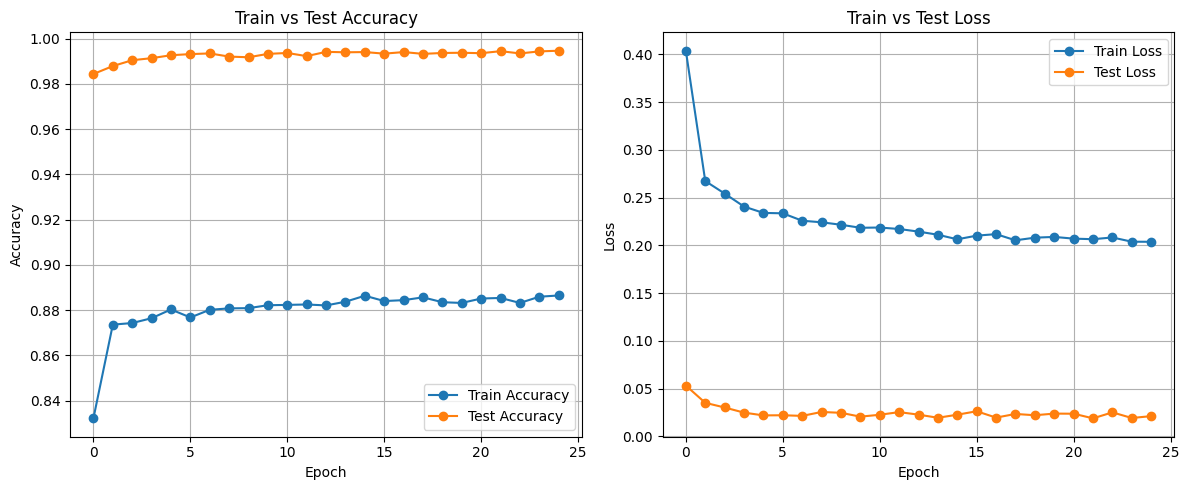

View run in W&B: https://wandb.ai/jsrodriguez16-personal/mnist/runs/jgov8m5x
View project in W&B: https://wandb.ai/jsrodriguez16-personal/mnist


In [40]:
h.plot_wandb_run_metrics(entity="jsrodriguez16-personal",
                       project="mnist",
                       run_id="jgov8m5x")

In [22]:
# Define model
fashionMNIST_model_2=models.TinyVGG(in_channels=1,
                       hidden_units=[32,32],
                       out_features=10,
                       dropout=0.2).to(device)
# Set optimizer
fashionMNIST_optimizer = torch.optim.Adam(params=fashionMNIST_model_2.parameters(), lr=0.001)


In [23]:
torch.manual_seed(42)
h.train_with_wandb(model=fashionMNIST_model_2,
                 train_loader=fashionMNIST_train_loader,
                 test_loader=fashionMNIST_test_loader,
                 loss_fn=loss_fn,
                 optimizer=fashionMNIST_optimizer,
                 accuracy_fn=h.accuracy_fn,
                 device=device,
                 epochs=30,
                 project_name="fashion mnist",
                 hidden_units=[32,32],
                 dropout=0.2)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 
---------
Train loss: 0.70521 | Train acc: 72.47%


  3%|▎         | 1/30 [00:13<06:22, 13.18s/it]

Test loss: 0.35517 | Test acc: 87.79%

Epoch: 1 
---------
Train loss: 0.53921 | Train acc: 78.14%


  7%|▋         | 2/30 [00:26<06:07, 13.11s/it]

Test loss: 0.31317 | Test acc: 88.35%

Epoch: 2 
---------
Train loss: 0.50182 | Train acc: 79.24%


 10%|█         | 3/30 [00:39<05:54, 13.12s/it]

Test loss: 0.26580 | Test acc: 90.41%

Epoch: 3 
---------
Train loss: 0.47190 | Train acc: 80.22%


 13%|█▎        | 4/30 [00:52<05:41, 13.13s/it]

Test loss: 0.25279 | Test acc: 90.73%

Epoch: 4 
---------
Train loss: 0.45548 | Train acc: 80.79%


 17%|█▋        | 5/30 [01:05<05:27, 13.08s/it]

Test loss: 0.24220 | Test acc: 91.28%

Epoch: 5 
---------
Train loss: 0.44950 | Train acc: 80.92%


 20%|██        | 6/30 [01:18<05:13, 13.08s/it]

Test loss: 0.23698 | Test acc: 91.37%

Epoch: 6 
---------
Train loss: 0.43858 | Train acc: 81.29%


 23%|██▎       | 7/30 [01:31<05:00, 13.06s/it]

Test loss: 0.22742 | Test acc: 91.93%

Epoch: 7 
---------
Train loss: 0.43194 | Train acc: 81.47%


 27%|██▋       | 8/30 [01:44<04:47, 13.06s/it]

Test loss: 0.22668 | Test acc: 91.60%

Epoch: 8 
---------
Train loss: 0.42355 | Train acc: 81.66%


 30%|███       | 9/30 [01:57<04:33, 13.03s/it]

Test loss: 0.22507 | Test acc: 91.73%

Epoch: 9 
---------
Train loss: 0.41499 | Train acc: 82.08%


 33%|███▎      | 10/30 [02:10<04:20, 13.01s/it]

Test loss: 0.23645 | Test acc: 91.56%

Epoch: 10 
---------
Train loss: 0.41558 | Train acc: 81.82%


 37%|███▋      | 11/30 [02:23<04:06, 13.00s/it]

Test loss: 0.22076 | Test acc: 92.25%

Epoch: 11 
---------
Train loss: 0.40563 | Train acc: 82.30%


 40%|████      | 12/30 [02:36<03:54, 13.02s/it]

Test loss: 0.22893 | Test acc: 91.93%

Epoch: 12 
---------
Train loss: 0.39655 | Train acc: 82.67%


 43%|████▎     | 13/30 [02:49<03:41, 13.02s/it]

Test loss: 0.23794 | Test acc: 91.44%

Epoch: 13 
---------
Train loss: 0.39676 | Train acc: 82.38%


 47%|████▋     | 14/30 [03:02<03:28, 13.00s/it]

Test loss: 0.21669 | Test acc: 92.37%

Epoch: 14 
---------
Train loss: 0.39647 | Train acc: 82.56%


 50%|█████     | 15/30 [03:15<03:15, 13.01s/it]

Test loss: 0.22188 | Test acc: 92.06%

Epoch: 15 
---------
Train loss: 0.39476 | Train acc: 82.54%


 53%|█████▎    | 16/30 [03:28<03:02, 13.05s/it]

Test loss: 0.21633 | Test acc: 92.33%

Epoch: 16 
---------
Train loss: 0.38708 | Train acc: 82.83%


 57%|█████▋    | 17/30 [03:41<02:49, 13.06s/it]

Test loss: 0.22082 | Test acc: 92.13%

Epoch: 17 
---------
Train loss: 0.38445 | Train acc: 82.59%


 60%|██████    | 18/30 [03:54<02:36, 13.06s/it]

Test loss: 0.22103 | Test acc: 92.53%

Epoch: 18 
---------
Train loss: 0.38450 | Train acc: 82.80%


 63%|██████▎   | 19/30 [04:08<02:23, 13.09s/it]

Test loss: 0.21665 | Test acc: 92.49%

Epoch: 19 
---------
Train loss: 0.38139 | Train acc: 82.99%


 67%|██████▋   | 20/30 [04:21<02:10, 13.09s/it]

Test loss: 0.23763 | Test acc: 91.88%

Epoch: 20 
---------
Train loss: 0.38356 | Train acc: 82.67%


 70%|███████   | 21/30 [04:34<01:58, 13.12s/it]

Test loss: 0.21626 | Test acc: 92.48%

Epoch: 21 
---------
Train loss: 0.38000 | Train acc: 82.93%


 73%|███████▎  | 22/30 [04:47<01:45, 13.14s/it]

Test loss: 0.23023 | Test acc: 92.35%

Epoch: 22 
---------
Train loss: 0.37931 | Train acc: 83.00%


 77%|███████▋  | 23/30 [05:00<01:31, 13.14s/it]

Test loss: 0.21596 | Test acc: 92.42%

Epoch: 23 
---------
Train loss: 0.37602 | Train acc: 82.99%


 80%|████████  | 24/30 [05:13<01:18, 13.12s/it]

Test loss: 0.21736 | Test acc: 92.51%

Epoch: 24 
---------
Train loss: 0.37226 | Train acc: 83.25%


 83%|████████▎ | 25/30 [05:26<01:05, 13.13s/it]

Test loss: 0.21598 | Test acc: 92.77%

Epoch: 25 
---------
Train loss: 0.37353 | Train acc: 83.19%


 87%|████████▋ | 26/30 [05:40<00:52, 13.16s/it]

Test loss: 0.23431 | Test acc: 91.76%

Epoch: 26 
---------
Train loss: 0.37490 | Train acc: 83.21%


 90%|█████████ | 27/30 [05:53<00:39, 13.14s/it]

Test loss: 0.21914 | Test acc: 92.57%

Epoch: 27 
---------
Train loss: 0.36515 | Train acc: 83.40%


 93%|█████████▎| 28/30 [06:14<00:31, 15.65s/it]

Test loss: 0.21699 | Test acc: 92.50%

Epoch: 28 
---------
Train loss: 0.36466 | Train acc: 83.41%


 97%|█████████▋| 29/30 [06:32<00:16, 16.42s/it]

Test loss: 0.21755 | Test acc: 92.44%

Epoch: 29 
---------
Train loss: 0.36631 | Train acc: 83.41%


100%|██████████| 30/30 [06:49<00:00, 13.64s/it]

Test loss: 0.22409 | Test acc: 92.33%



epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_acc,▁▂▅▅▆▆▇▆▇▆▇▇▆▇▇▇▇██▇█▇███▇███▇
test_loss,█▆▄▃▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁
train_acc,▁▅▅▆▆▆▇▇▇▇▇▇█▇▇▇█▇████████████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
test_acc,0.92332
test_loss,0.22409
train_acc,0.83405
train_loss,0.36631


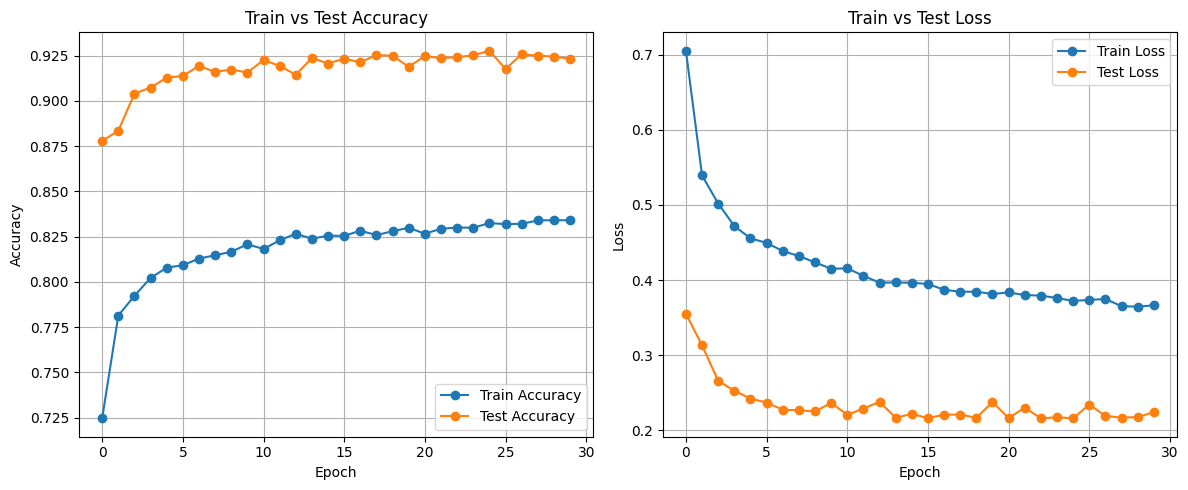

View run in W&B: https://wandb.ai/jsrodriguez16-personal/fashion+mnist/runs/9q10j6a6
View project in W&B: https://wandb.ai/jsrodriguez16-personal/fashion mnist


In [42]:
h.plot_wandb_run_metrics(entity="jsrodriguez16-personal",
                       project="fashion mnist",
                       run_id="9q10j6a6")

We see that there is a significative improvement when we increase the number of hidden units and add dropout to avoid overfitting.

## Saving our models


We can save our modles using our helper function.

In [43]:
h.save_model_dict(model=MNIST_model_1,
                model_name="mnist_model.pth",
                path="models")

Saving model to: models/mnist_model.pth


In [44]:
h.save_model_dict(model=fashionMNIST_model_2,
                model_name="fashionMnist_model.pth",
                path="models")

Saving model to: models/fashionMnist_model.pth


# Getting results in a pandas DataFrame
We can import all the experiments performed in Weights & Biases and sort them by test accuracy to select the best model.  
Note that there are multiple experiments not shown in this notebook, and some experiments may be repeated.  
There is also room for further experimentation by changing the batch size, learning rate, or adding more hidden layers to the model.  
However, to keep this notebook simple, we do not perform additional experiments here.



In [26]:

MNIST_experiments_df =  h.get_experiments_from_wandb("jsrodriguez16-personal", 'mnist')
MNIST_experiments_df.sort_values(by="test_acc", ascending=False)

,name,epochs,batch_size,optimizer,lr,train_acc,train_loss,test_acc,test_loss,hidden_units,url
19,graceful-spaceship-24,25,32,Adam,0.001,0.886483,0.203789,0.994609,0.021237,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
11,super-surf-16,15,32,Adam,0.001,0.886367,0.205776,0.994509,0.021940,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
14,exalted-oath-19,14,32,Adam,0.001,0.883783,0.210982,0.994209,0.022613,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
15,worldly-mountain-20,25,32,Adam,0.001,0.887083,0.201794,0.994209,0.024337,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
13,swift-water-18,15,32,Adam,0.001,0.886183,0.206367,0.993411,0.019741,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
6,icy-field-11,15,32,SGD,0.100,0.996133,0.011954,0.991813,0.031459,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
10,dandy-river-15,15,32,SGD,0.100,0.995500,0.014475,0.990915,0.031521,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
18,ancient-water-23,15,32,SGD,0.100,0.996000,0.012655,0.990116,0.033197,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
8,celestial-silence-13,15,32,SGD,0.100,0.994650,0.016624,0.989716,0.034885,None,https://wandb.ai/jsrodriguez16-personal/mnist/...
4,genial-hill-9,10,32,SGD,0.100,0.994367,0.017090,0.988818,0.036133,None,https://wandb.ai/jsrodriguez16-personal/mnist/...


In [27]:

fashionMNIST_experiments_df =  h.get_experiments_from_wandb("jsrodriguez16-personal", 'fashion mnist')
fashionMNIST_experiments_df.sort_values(by="test_acc", ascending=False)

,name,epochs,batch_size,optimizer,lr,train_acc,train_loss,test_acc,test_loss,hidden_units,url
24,still-bee-27,17,32,Adam,0.001,0.828150,0.386554,0.929014,0.209574,None,https://wandb.ai/jsrodriguez16-personal/fashio...
28,zany-breeze-31,30,32,Adam,0.001,0.831950,0.371247,0.926418,0.223182,None,https://wandb.ai/jsrodriguez16-personal/fashio...
26,light-bird-29,15,32,Adam,0.001,0.830617,0.376080,0.926018,0.221009,None,https://wandb.ai/jsrodriguez16-personal/fashio...
21,classic-meadow-24,17,32,Adam,0.001,0.824700,0.393587,0.924421,0.218751,None,https://wandb.ai/jsrodriguez16-personal/fashio...
11,sunny-wave-14,17,32,Adam,0.001,0.824967,0.392043,0.923423,0.213845,None,https://wandb.ai/jsrodriguez16-personal/fashio...
32,trim-wood-35,30,32,Adam,0.001,0.834050,0.366308,0.923323,0.224094,None,https://wandb.ai/jsrodriguez16-personal/fashio...
6,mild-surf-9,16,32,Adam,0.001,0.823917,0.399728,0.922823,0.221498,None,https://wandb.ai/jsrodriguez16-personal/fashio...
25,icy-spaceship-28,17,32,Adam,0.001,0.823017,0.399687,0.921326,0.224819,None,https://wandb.ai/jsrodriguez16-personal/fashio...
7,snowy-cherry-10,17,32,Adam,0.001,0.815100,0.434981,0.916733,0.225134,None,https://wandb.ai/jsrodriguez16-personal/fashio...
23,desert-totem-26,10,32,Adam,0.001,0.933967,0.181981,0.912141,0.247499,None,https://wandb.ai/jsrodriguez16-personal/fashio...


# Exploring our saved models
In this section, we load the models from the `state_dict` files (`mnist_model.pth` and `fashionMnist_model.pth`) and analyze the data instances where the models fail to produce correct predictions.



In [28]:
# Create instances of our models
mnist_model = models.TinyVGG(in_channels=1,
                       hidden_units=[32,32],
                       out_features=10,
                       dropout=0.2).to(device)

fashion_model = models.TinyVGG(in_channels=1,
                       hidden_units=[32,32],
                       out_features=10,
                       dropout=0.2).to(device)

# Load the state_dict
mnist_model.load_state_dict(torch.load(f="/content/models/mnist_model.pth"))
fashion_model.load_state_dict(torch.load(f="/content/models/fashionMnist_model.pth"))

<All keys matched successfully>

We can use our `test_step` function to test our models.

In [45]:
print("---------Performance of mnist_model ---------------")
_ , _=h.test_step(model=mnist_model,
          data_loader=MNIST_test_loader,
          loss_fn=loss_fn,
          accuracy_fn=h.accuracy_fn,
          device=device)

---------Performance of mnist_model ---------------
Test loss: 0.02124 | Test acc: 99.46%



In [30]:
print("---------Performance of fashion_model ---------------")
_ , _=h.test_step(model=fashion_model,
          data_loader=fashionMNIST_test_loader,
          loss_fn=loss_fn,
          accuracy_fn=h.accuracy_fn,
          device=device)

---------Performance of fashion_model ---------------
Test loss: 0.22409 | Test acc: 92.33%



To end this notebook, we can explore the images where our models made incorrect predictions.  
We use the helper function `get_error_indices` to obtain the indices of the misclassified samples in the dataset.  

Once we have these indices, we can create a subset of the dataset containing only the misclassified images and use the helper function `make_predictions_loader` to get the predicted labels for these images. Finally, we can visualize them using `plot_images_grid`, which displays the images in a grid along with their true labels and predicted labels.  




Total misclassified images: 54


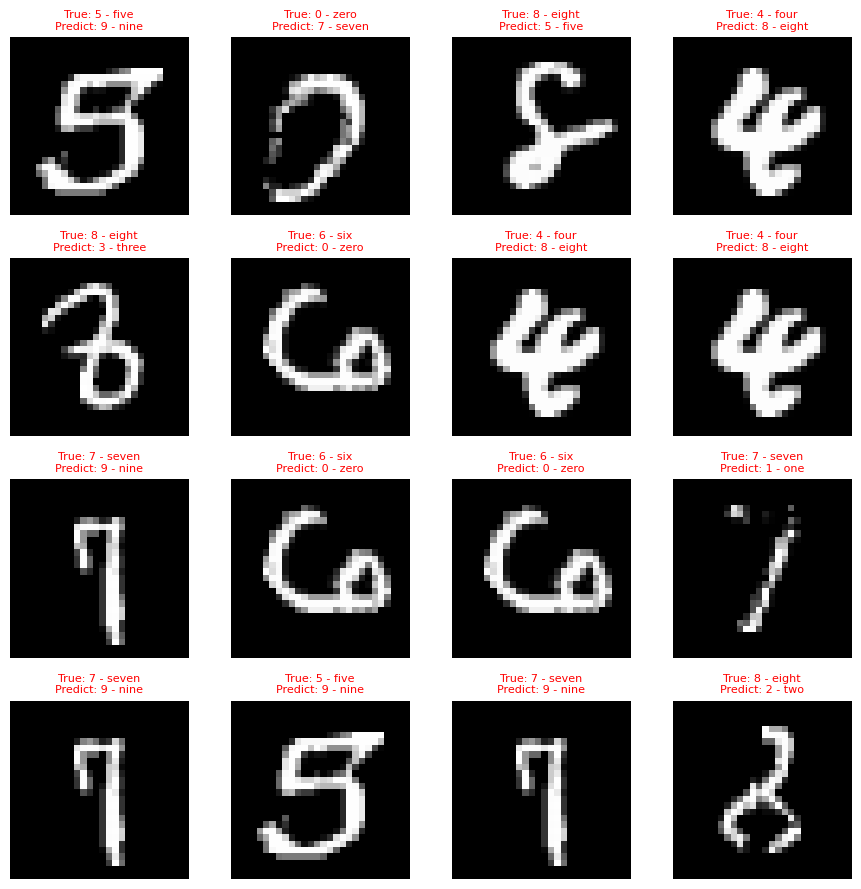

In [31]:
h.plot_misclassified_subset(
    model=mnist_model,
    dataset=MNIST_test_data,
    loader=MNIST_test_loader,
    device=device,
    num_to_plot=16,
    cols=4
)


Total misclassified images: 767


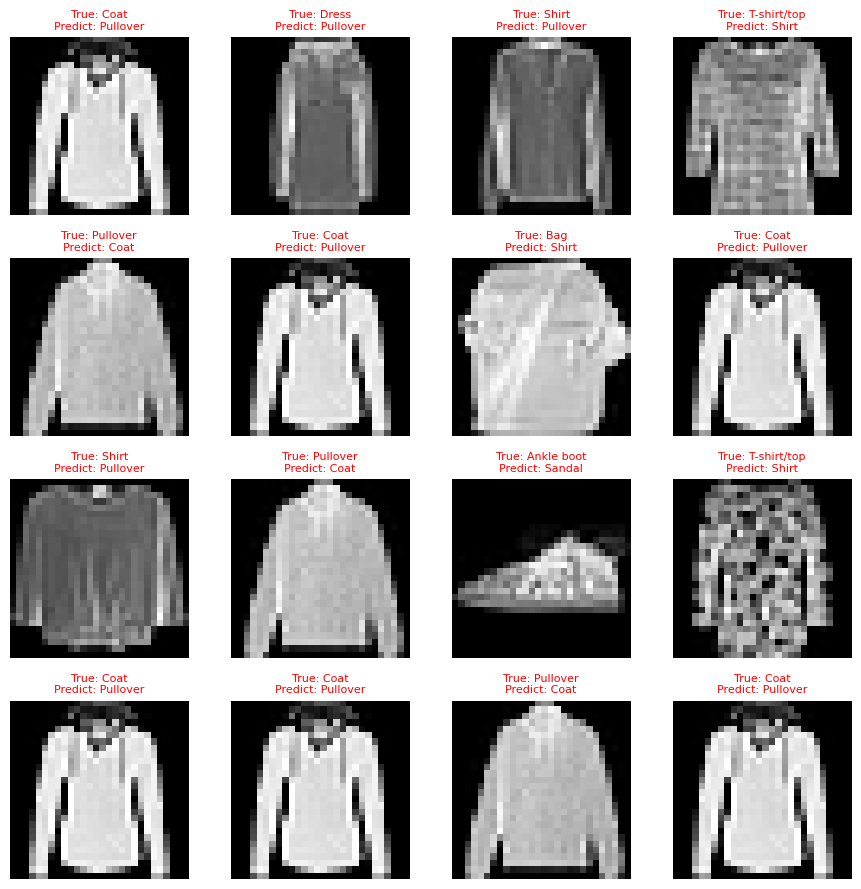

In [32]:
h.plot_misclassified_subset(
    model=fashion_model,
    dataset=fashionMNIST_test_data,
    loader=fashionMNIST_test_loader,
    device=device,
    num_to_plot=16,
    cols=4
)


We can also plot the confusion matrix

------------------------------------- MNIST ---------------------------------------------


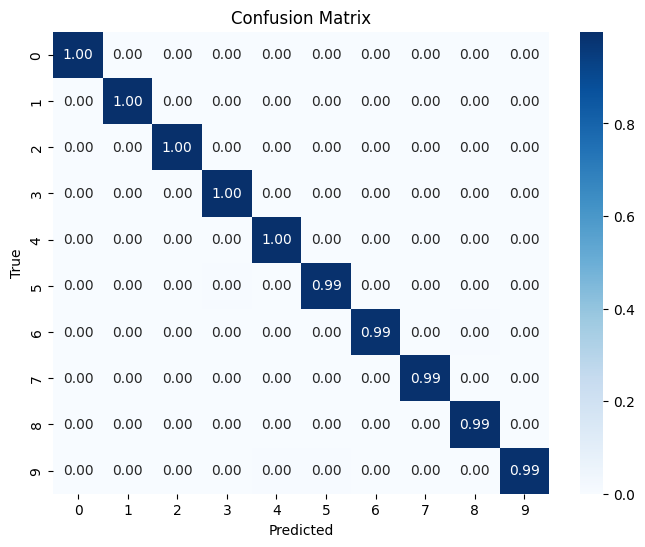

In [33]:
class_names_mnist = [str(i) for i in range(10)]
print("------------------------------------- MNIST ---------------------------------------------")
h.plot_confusion_matrix(mnist_model, MNIST_test_loader, device, class_names_mnist)


------------------------------------- fashion-MNIST ---------------------------------------------


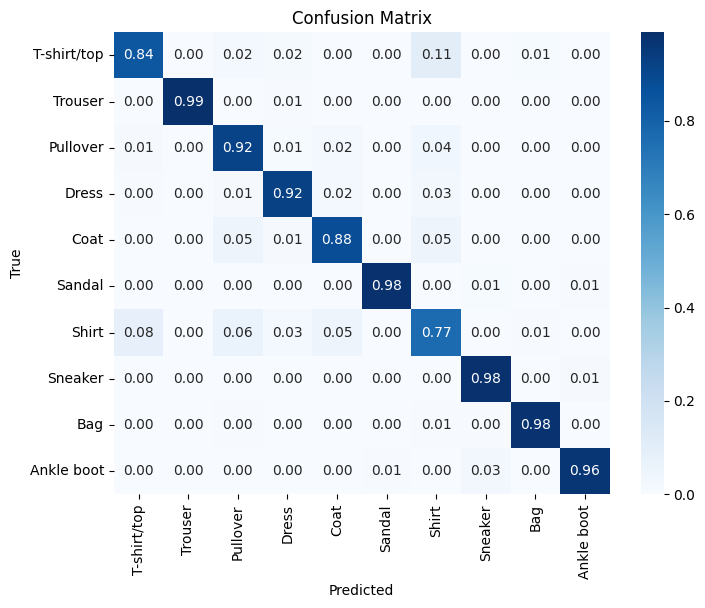

In [34]:
print("------------------------------------- fashion-MNIST ---------------------------------------------")
h.plot_confusion_matrix(fashion_model, fashionMNIST_test_loader, device, fashionMNIST_classes)


## Conclusions

In this project, we implemented and evaluated classifiers for the MNIST and Fashion-MNIST datasets.  

The final **MNIST model achieved excellent performance**, with a test accuracy of **99.46%** and a very low test loss (**0.02124**), confirming that handwritten digits are relatively easy to classify due to their clear and distinct visual patterns.  

The **Fashion-MNIST model reached a test accuracy of 92.33%** with a test loss of **0.22409**, highlighting that this dataset is more challenging. Many classes, such as T-shirts and shirts, have very similar visual characteristics, which leads to more misclassifications.  

Both models were designed with a **simple architecture of two hidden layers with 32 units each**, which proved effective but leaves room for experimentation. Future work could explore **deeper architectures with more layers and more hidden units**, as well as other network designs.  

We also used **Weights & Biases (wandb)** to log and save experiments. While in this project wandb was used primarily for tracking, it can also be leveraged for **hyperparameter sweeps** to systematically explore different learning rates, optimizers, hidden units, or other configurations to further improve performance.  

Overall, these results illustrate the importance of **hyperparameter tuning, model architecture design, and careful analysis of misclassified examples** for achieving high accuracy, especially in datasets with visually similar classes like Fashion-MNIST.

